In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import stats
import os
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GroupKFold
import pickle
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import ExponentialSmoothing
import itertools
#from prophet import Prophet

In [2]:
#os.chdir('C:\\Users\\polet\\Desktop\\FER\\Detekcija anomalija\\input')
os.chdir('/home/ninio/PycharmProjects/Detekcija-anomalija/input')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./sample_submission.csv
./test.csv
./mi_scores_sorted.pkl
./mi_scores_dict.pkl
./train.csv
./temp_X_test.pkl
./temp_X_train.pkl


In [3]:
temp_X_train = pd.read_pickle('temp_X_train.pkl')
temp_X_test = pd.read_pickle('temp_X_test.pkl')

with open('mi_scores_sorted.pkl', 'rb') as f:
    mi_scores_sorted1 = pickle.load(f)

with open('mi_scores_dict.pkl', 'rb') as f:
    mi_scores_dict1 = pickle.load(f)

In [4]:
temp_X_train.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,broken_kurtosis,daily_broken_rate_kurtosis,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15
0,0,0,1273,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,1218,0,AI100196,2.00,0.001642,0.0,0.0,0.0,...,0.000000,0.0,2.0000,0.000821,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,717,0,AI100196,1.00,0.002789,0.0,0.0,0.0,...,0.000000,0.0,1.5000,0.001477,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,399,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.000000,0.0,1.0000,0.001108,0.0,0.0,0.0,0.0,0.0,0.0
4,4,3,436,0,AI100196,0.75,0.006881,1.8,0.0,1.4,...,-1.601852,0.0,0.9375,0.002262,0.0,0.0,0.0,0.0,0.0,0.0


1. Data preparation
    Find a machine that has seasonality in the feature total. Plot signals from the selected machine using the function from the first exercise.



In [5]:
#Preparing the data so we have easier time to find the seasonality
df_train = temp_X_train.copy()
df_test = temp_X_test.copy()

df_train['timedelta'] = pd.to_timedelta(df_train['day'], unit='D')
initial_timestamp = pd.Timestamp('2018-06-15 00:00:00')
df_train['timestamp'] = initial_timestamp + df_train['timedelta']
df_train.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15,timedelta,timestamp
0,0,0,1273,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0 days,2018-06-15
1,1,2,1218,0,AI100196,2.00,0.001642,0.0,0.0,0.0,...,2.0000,0.000821,0.0,0.0,0.0,0.0,0.0,0.0,1 days,2018-06-16
2,2,2,717,0,AI100196,1.00,0.002789,0.0,0.0,0.0,...,1.5000,0.001477,0.0,0.0,0.0,0.0,0.0,0.0,2 days,2018-06-17
3,3,0,399,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,1.0000,0.001108,0.0,0.0,0.0,0.0,0.0,0.0,3 days,2018-06-18
4,4,3,436,0,AI100196,0.75,0.006881,1.8,0.0,1.4,...,0.9375,0.002262,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2018-06-19


In [12]:
#Function from first exercise
def plot_machine_signals(df,machine_name):
    machine_data = df[df['machine_name'] == machine_name]
    signal_names = ['broken', 'total','label']
    fig, axs = plt.subplots(len(signal_names), 1, figsize=(15, 5*len(signal_names)))

    for i, signal_name in enumerate(signal_names):
        axs[i].plot(machine_data['day'], machine_data[signal_name])
        axs[i].set_ylabel(signal_name)

        if machine_data['label'].max() == 1:
            min_day = machine_data[machine_data['label'] == 1]['day'].min()
            max_day = machine_data[machine_data['label'] == 1]['day'].max()
            axs[i].axvspan(xmin = min_day , xmax = max_day, color='red',alpha=0.8)
    fig.suptitle(f'Signals for Machine {machine_name}')
    plt.show()

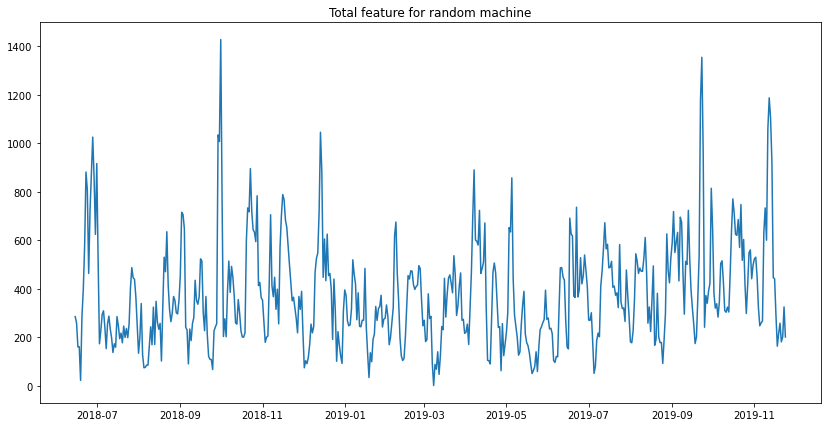

In [11]:
#We are using the autocorrelation to find seasonality machine
#For example we can select random machine
selected_machine = df_train[df_train['machine_name'] == 'CS103864']

#Lets graph the total feature
plt.figure(figsize=(14, 7))
plt.plot(selected_machine['timestamp'], selected_machine['total'])
plt.title('Total feature for random machine')
plt.show()

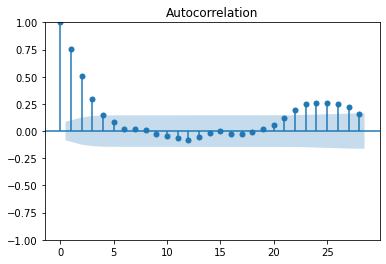

In [13]:
#Lets show its autocorrelation
plot_acf(selected_machine['total'].dropna())
plt.show()

In the ACF plot, if you see regularly spaced significant spikes, this indicates seasonality.
In this case, the spikes are not regularly spaced, so there is no seasonality in the signal.

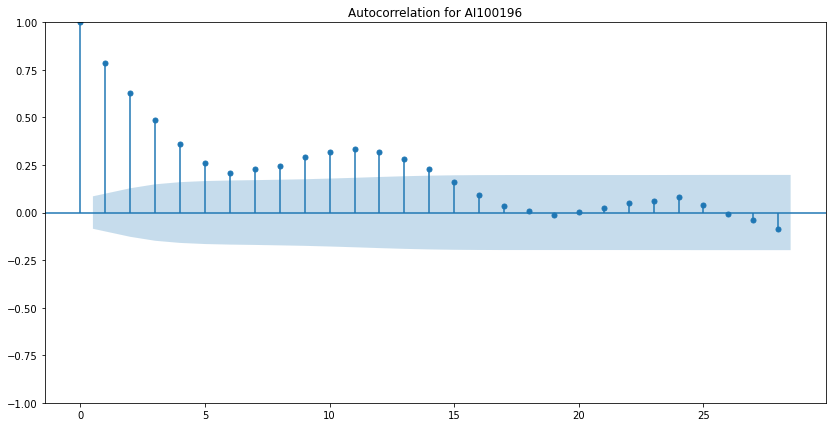

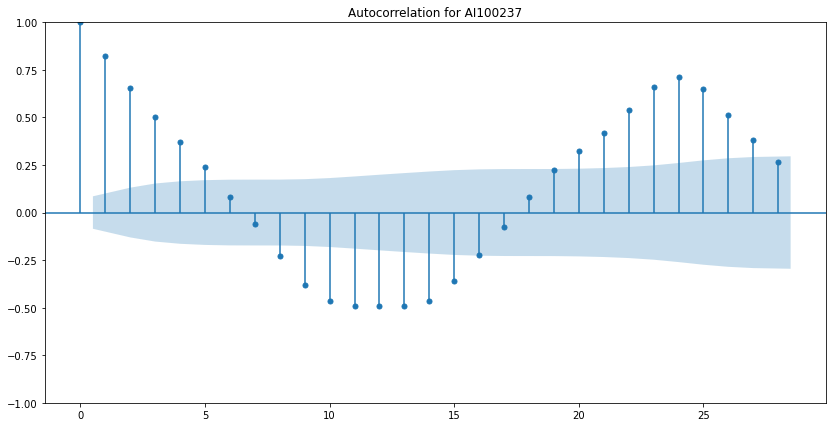

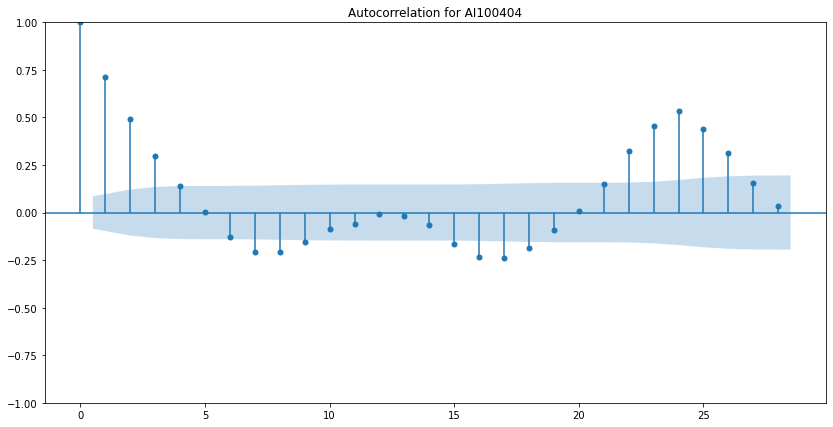

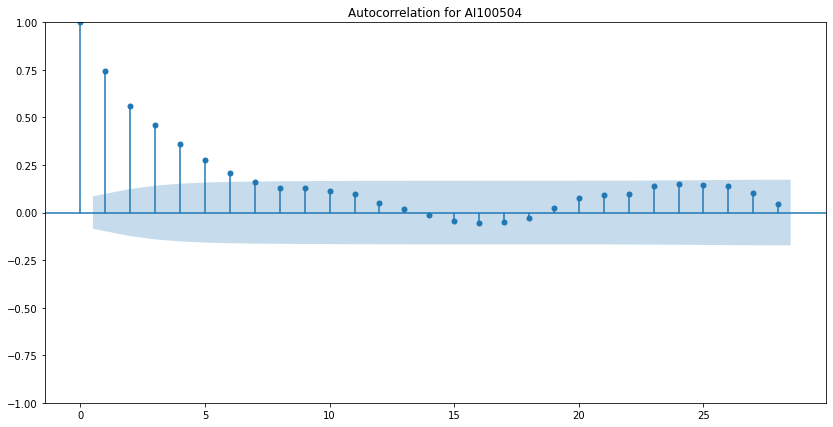

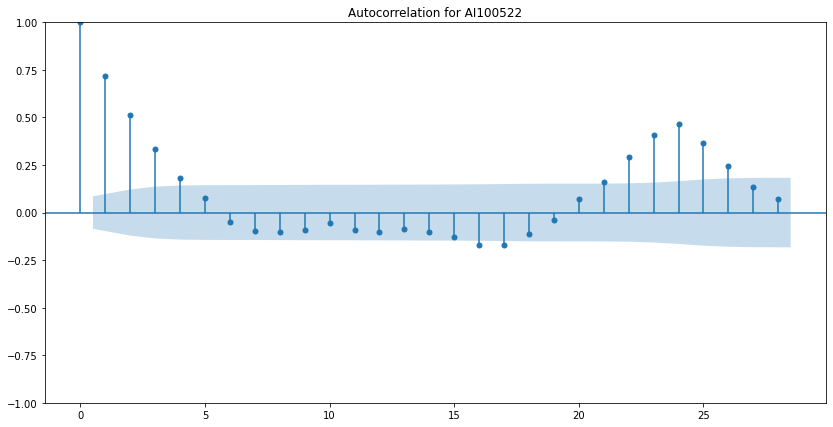

In [15]:
#Using autocorellation for selected machines it will be easier to find pattern or seasonality in the data
machine_names = df_train['machine_name'].unique()

for machine in machine_names[0:5]:
    selected_machine = df_train[df_train['machine_name'] == machine]
    if selected_machine.empty:
        continue
    plt.figure(figsize=(14,7))
    plot_acf(selected_machine['total'].dropna(), ax=plt.gca(), title=f'Autocorrelation for {machine}')
    plt.show()

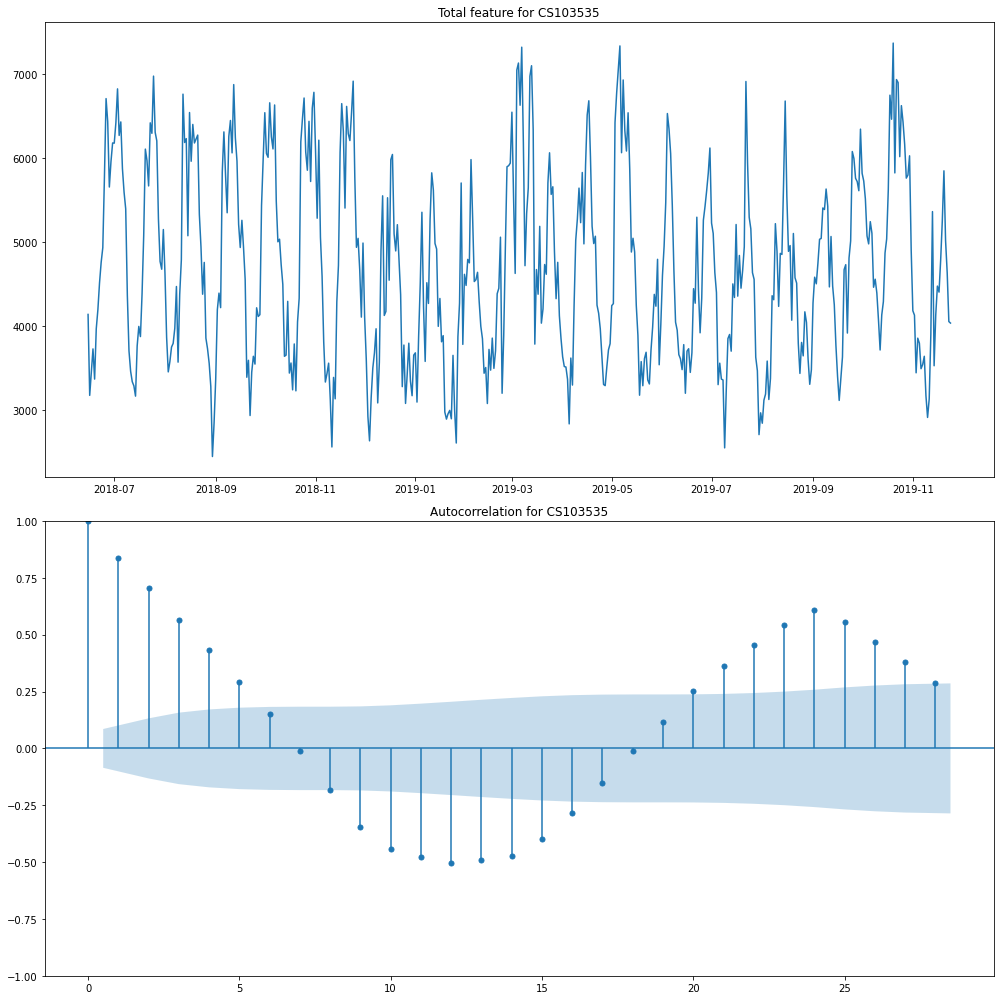

In [14]:
#manually from looking at the graphs I selected a machine that has a sensonality
selected_machine = df_train[df_train['machine_name'] == 'CS103535']
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
ax[0].plot(selected_machine['timestamp'], selected_machine['total'])
ax[0].set_title('Total feature for CS103535')

plot_acf(selected_machine['total'].dropna(), ax=ax[1], title=f'Autocorrelation for CS103535')

plt.tight_layout()
plt.show()

As you can see this machine has seasonality  because in a time series is a repeating pattern observed within each period.

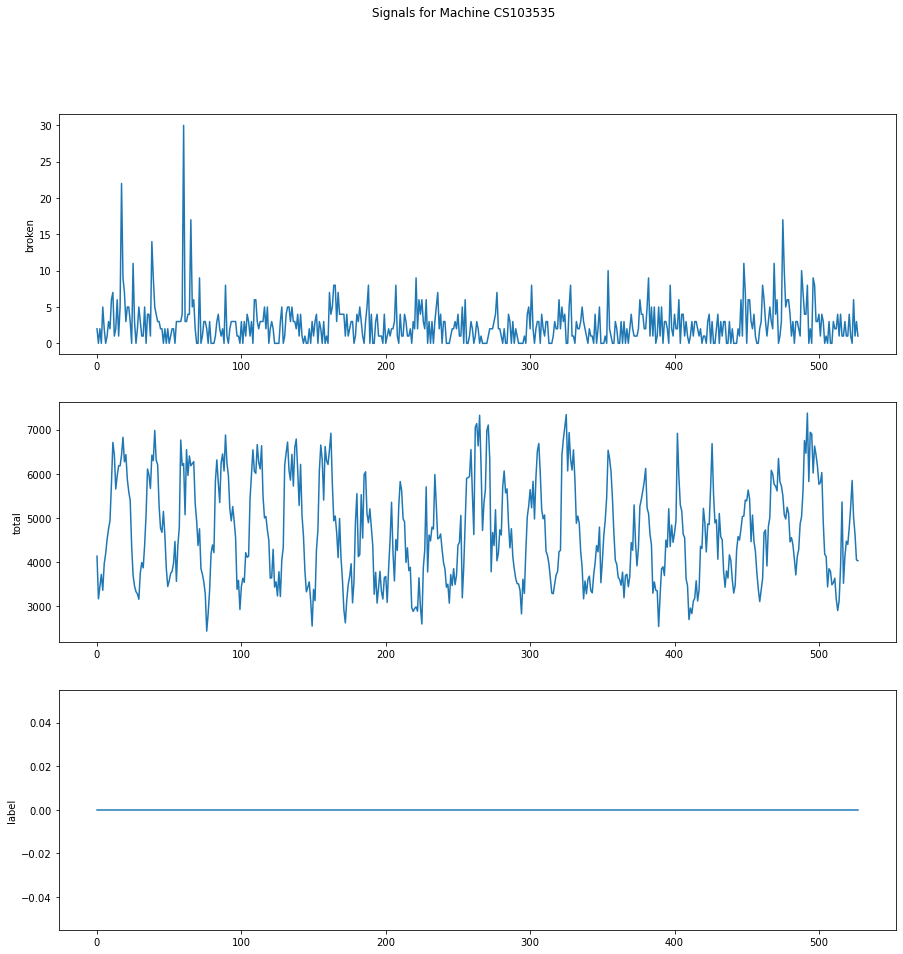

In [11]:
#Using a function from first exercise
plot_machine_signals(df_train,'CS103535')


2. Exponential smoothing
    Use 70% of the samples as a training set and the rest as a test set. Apply the exponential smoothing method (from statsmodels.tsa.holtwinters import ExponentialSmoothing) on the training set and forecast test set. Calculate the root mean square error and the mean absolute error of your prediction.
    Display a line graph showing the training set, the test set, and the predicted values of the exponential smoothing model. Do you find obtained predictions useful? Why?
    Try some form of parameter optimization to get a more accurate model. Do you manage to improve the model? Show a table of the parameters used and the errors obtained using these parameters.



In [6]:
df = temp_X_train.copy()
df['timedelta'] = pd.to_timedelta(df['day'], unit='D')
initial_timestamp = pd.Timestamp('2018-06-15 00:00:00')
df['timestamp'] = initial_timestamp + df['timedelta']
df.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15,timedelta,timestamp
0,0,0,1273,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0 days,2018-06-15
1,1,2,1218,0,AI100196,2.00,0.001642,0.0,0.0,0.0,...,2.0000,0.000821,0.0,0.0,0.0,0.0,0.0,0.0,1 days,2018-06-16
2,2,2,717,0,AI100196,1.00,0.002789,0.0,0.0,0.0,...,1.5000,0.001477,0.0,0.0,0.0,0.0,0.0,0.0,2 days,2018-06-17
3,3,0,399,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,1.0000,0.001108,0.0,0.0,0.0,0.0,0.0,0.0,3 days,2018-06-18
4,4,3,436,0,AI100196,0.75,0.006881,1.8,0.0,1.4,...,0.9375,0.002262,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2018-06-19


In [7]:
X = df.copy()
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [8]:
X_train['total'].head()

0    1273
1    1218
2     717
3     399
4     436
Name: total, dtype: int64

In [50]:
X_train_transformed = X_train['total'] + 0.01

model = ExponentialSmoothing(X_train_transformed,seasonal_periods=20,trend=None, seasonal='add')
model_fit = model.fit()
pred = model_fit.forecast(len(X_test))
rmse = np.sqrt(mean_squared_error(X_test['total'], pred))
mae = mean_absolute_error(X_test['total'], pred)

print(f'RMSE: {rmse}, MAE: {mae}')

/home/ninio/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


RMSE: 2690.0317989097125, MAE: 1734.5893730705816


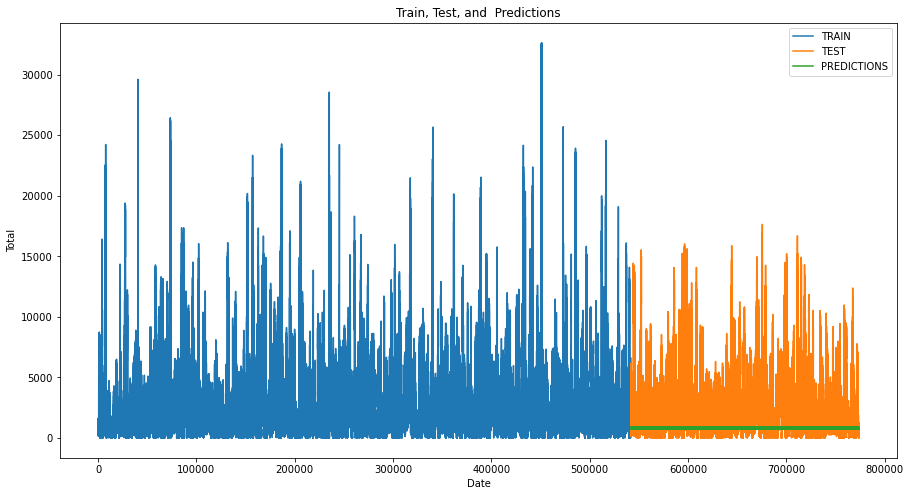

In [51]:
test_predictions_series = pd.Series(pred, index=X_test.index)

X_train['total'].plot(legend=True, label='TRAIN', figsize=(15, 8))
X_test['total'].plot(legend=True, label='TEST', figsize=(15, 8))
test_predictions_series.plot(legend=True, label='PREDICTIONS', figsize=(15, 8))

plt.title('Train, Test, and  Predictions')
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()

In [49]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Define the parameter values to try
seasonal_periods_values = [10, 20, 30]  # Example values for seasonal_periods
seasonal_values = ['add', 'mul']  # Example values for seasonal

# Initialize lists to store the results
results_rmse = []
results_mae = []

# Iterate over the parameter values
for seasonal_periods in seasonal_periods_values:
    for seasonal in seasonal_values:
        # Configure and fit the model
        model = ExponentialSmoothing(X_train_transformed, seasonal_periods=seasonal_periods, trend=None, seasonal=seasonal)
        model_fit = model.fit()

        # Make predictions
        pred = model_fit.forecast(len(X_test))

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(X_test['total'], pred))
        mae = mean_absolute_error(X_test['total'], pred)

        # Store the results
        results_rmse.append((seasonal_periods, seasonal, rmse))
        results_mae.append((seasonal_periods, seasonal, mae))

# Print the results
for result in results_rmse:
    print(f"Seasonal Periods: {result[0]}, Seasonal: {result[1]}, RMSE: {result[2]}")

for result in results_mae:
    print(f"Seasonal Periods: {result[0]}, Seasonal: {result[1]}, MAE: {result[2]}")


/home/ninio/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/ninio/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/ninio/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/ninio/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/ninio/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/ninio/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: Con

Seasonal Periods: 10, Seasonal: add, RMSE: 2676.7405853251603
Seasonal Periods: 10, Seasonal: mul, RMSE: 3438.549068124938
Seasonal Periods: 20, Seasonal: add, RMSE: 2690.0317989097125
Seasonal Periods: 20, Seasonal: mul, RMSE: 3601.259995841586
Seasonal Periods: 30, Seasonal: add, RMSE: 2681.8275421887643
Seasonal Periods: 30, Seasonal: mul, RMSE: 2931.5362729351987
Seasonal Periods: 10, Seasonal: add, MAE: 1723.821365892312
Seasonal Periods: 10, Seasonal: mul, MAE: 2609.8554307607583
Seasonal Periods: 20, Seasonal: add, MAE: 1734.5893730705816
Seasonal Periods: 20, Seasonal: mul, MAE: 2470.3854684507196
Seasonal Periods: 30, Seasonal: add, MAE: 1727.7133800937443
Seasonal Periods: 30, Seasonal: mul, MAE: 1985.0423455032844


3. ARIMA
    Use 70% of the samples as a training set and the rest as a test set. Apply the ARIMA model (from statsmodels.tsa.arima.model import ARIMA) with predefined parameters (0,0,0) and predict the values of the test set. Calculate the root mean square error and the mean absolute error of your prediction. Display a line graph showing the training set, the test set, and the predicted values of the ARIMA model along with the prediction confidence interval. What does the width of the confidence interval suggest? Do you find obtained prediction useful? Why?
    Try a few different values of the p parameter and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does the parameter p affect the appearance of the prediction?
    Try a few different values of the q parameter and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does the q parameter affect the appearance of the prediction?
    Try a few different values of parameter d and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does parameter d affect the appearance of the prediction?
    Perform the optimization of the parameters p, d and q at the same time and try to reduce the error. Do you manage to significantly improve the model? Display a line graph of the prediction with the least error.
    Try changing the parameter s (seasonality). Do you manage to reduce the error? Display a line prediction graph with the least error. How does the s parameter affect the appearance of the prediction?
    Show a table of the parameters used and the errors obtained using these parameters.



In [ ]:
model = ARIMA(df['total'], order=(5,1,0)) # p, d, q
model_fit = model.fit()

print(model_fit.summary())

# Plot of the original series and the forecasted series
df['forecast'] = model_fit.predict(dynamic=True)
df[['total', 'forecast']].plot(figsize=(12, 8))
plt.show()


In [ ]:

# Function to calculate RMSE and MAE
def calculate_errors(actual, predicted):
    rmse = mean_squared_error(actual, predicted, squared=False)
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

# Generate combinations of p, d, q parameters
p_values = [0, 1, 2, 3]
d_values = [0]
q_values = [0, 1, 2, 3]

results = []

# Iterate over parameter combinations
for p, d, q in itertools.product(p_values, d_values, q_values):
    # Fit ARIMA model
    model = ARIMA(df['total'], order=(p, d, q))
    model_fit = model.fit()

    # Make predictions
    df['forecast'] = model_fit.predict(dynamic=True)

    # Calculate errors
    rmse, mae = calculate_errors(df['total'], df['forecast'])

    results.append({
        'p': p,
        'd': d,
        'q': q,
        'RMSE': rmse,
        'MAE': mae
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find parameters with minimum RMSE
min_rmse_idx = results_df['RMSE'].idxmin()
best_params = results_df.loc[min_rmse_idx, ['p', 'd', 'q']]
best_rmse = results_df.loc[min_rmse_idx, 'RMSE']
best_mae = results_df.loc[min_rmse_idx, 'MAE']

# Fit ARIMA model with best parameters
model = ARIMA(df['total'], order=(best_params['p'], best_params['d'], best_params['q']))
model_fit = model.fit()
df['forecast'] = model_fit.predict(dynamic=True)

# Plot of the original series and the forecasted series with best parameters
plt.figure(figsize=(12, 8))
plt.plot(df['total'], label='Original')
plt.plot(df['forecast'], label='Forecast')
plt.legend()
plt.show()

print("Best Parameters:")
print(best_params)
print("Best RMSE:", best_rmse)
print("Best MAE:", best_mae)
print("\nParameter Optimization Results:")
print(results_df)


4. Facebook Prophet
    Prophet (from fbprophet import Prophet) requires as the input set a DataFrame with columns ds and y. y is the value of our time series, and ds is a DateTime column with the moment of that event. Since we do not have information on the exact time, we will assume that the first sample was at timestamp 2018-06-15 00 : 00 : 00, and each subsequent sample was played 24H after the previous one.
    Train the Prophet algorithm on the first 70% of samples and make predictions for the rest of the signal. Using the built-in functions within the fbprophet library, draw a prediction graph and graphs of the individual predictive components of the Prophet algorithm. Calculate the root mean square error and the mean absolute error.
    Manually set the seasonalities observed in the signal (if any) and change their Fourier order parameter values. Do you manage to reduce the error? What prediction does the Prophet algorithm give compared to previously tested algorithms?
    Show a table of the parameters used and the errors obtained using these parameters.



In [ ]:
df['timedelta'] = pd.to_timedelta(df['day'], unit='D')
initial_timestamp = pd.Timestamp('2018-06-15 00:00:00')
df['timestamp'] = initial_timestamp + df['timedelta']
df.head()

In [ ]:
# Load the dataset
df = pd.read_csv('data.csv')

# Convert the column to datetime
df['date'] = pd.to_datetime(df['date'])

# Prophet requires columns ds (Date) and y (value)
df = df.rename(columns={'date': 'ds', 'value': 'y'})

# Make the prophet model and fit on the data
model_prophet = Prophet(daily_seasonality=True) # Enable daily seasonality for daily data, adjust as per the frequency of your data
model_prophet.fit(df)

# Create future dates
future = model_prophet.make_future_dataframe(periods=365) # Forecasting for 1 year from now.

# Predictions
forecast = model_prophet.predict(future)

# Plotting the forecast
model_prophet.plot(forecast)
plt.show()

# You can also view components of your forecast like trend and seasonality
model_prophet.plot_components(forecast)
plt.show()


5. RandomForestRegressor
    Use RandomForestRegressor to predict the total number. Use all features for the regression model. We set aside the first 70% of samples as a training set, and we test the model on the rest of the signal. Using features from the current sample, we predict the value for the feature total in the next sample.
    Train RandomForestRegressor using a training set. Predict the value of the feature total for the test set. Calculate the root mean square error and the mean absolute error. Display a line graph showing the training set, the test set, and the predicted values of the regression model. What are the results compared to those obtained by previously tested algorithms?



In [ ]:
# Load the dataset
df = pd.read_csv('data.csv')

# Convert the column to datetime and set it as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Create lagged dataset
def create_lagged_dataset(df, lag=1):
    df_lagged = pd.concat([df.shift(i) for i in range(lag+1)], axis=1)
    df_lagged.fillna(0, inplace=True)
    df_lagged.columns = ['lag_' + str(i) for i in range(lag+1)]
    return df_lagged

lag = 3  # you can adjust this value
df_lagged = create_lagged_dataset(df, lag)

# Split the data into training and test sets
train_size = int(len(df_lagged) * 0.8)
train, test = df_lagged[0:train_size], df_lagged[train_size:len(df_lagged)]

train_X, train_y = train.drop('lag_0', axis=1), train['lag_0']
test_X, test_y = test.drop('lag_0', axis=1), test['lag_0']

# Create the model and fit the data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(train_X, train_y)

# Make predictions
predictions = model_rf.predict(test_X)

# Check the mean squared error
mse = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % mse)

# Plotting
plt.plot(test_y.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


6.  Generated signal
    Use the code written below to generate a synthetic signal. Display the entire signal. What components does the generated signal consist of? Is there a signal periodicity? If yes, what is the period of periodicity and visualize the part of the signal where it can be seen. Is there a trend in the signal? If yes, what is it like?
    Repeat the assignments for exponential smoothing, ARIMA and Prophet using the signal generated this way.

In [ ]:
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 200 * t)
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63)
trend = np.linspace(0, 600, 600)/(134*np.pi)
trend1 = np.linspace(0, 100, 100)/(104*np.pi)
trend2 = np.linspace(0, 300, 300)/(-122*np.pi)
trend3 = np.linspace(0, 200, 200)/(111*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]